In [1]:
# ============================================================
# BCRA FX Bands Scheme Tracker
# FX A3500 + Bands 2025/2026 + Final Chart
#
# - Loads FX A3500 from BCRA Excel file.
# - Uses REM and official CPI to build daily FX bands.
#   2025: fixed ±1% monthly rule.
#   2026: inflation-based update with a t−2 lag.
# - Merges bands with observed A3500 and produces the final chart.
#
# Data sources:
# - REM (BCRA)
# - A3500 (BCRA)
# - Headline CPI (datos.gob.ar / INDEC)
# ============================================================


In [2]:
# 1) Libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 2) FX A3500 (com3500.xls)

def get_a3500():
    url = "https://www.bcra.gob.ar/Pdfs/PublicacionesEstadisticas/com3500.xls"
    fx = pd.read_excel(
        url, header=None, skiprows=4, usecols=[2, 3], engine="xlrd"
    )
    fx.columns = ["Date", "FX"]
    return (
        fx.assign(
            Date=lambda x: pd.to_datetime(x["Date"], errors="coerce"),
            FX=lambda x: pd.to_numeric(x["FX"], errors="coerce"),
        )
        .dropna(subset=["Date", "FX"])
        .sort_values("Date")
        .reset_index(drop=True)
    )


In [4]:
# 3) REM (latest publication, headline CPI, median)

def get_rem_last():
    url = (
        "https://www.bcra.gob.ar/archivos/Pdfs/PublicacionesEstadisticas/"
        "historico-relevamiento-expectativas-mercado.xlsx"
    )
    df = pd.read_excel(url, sheet_name="Base de Datos Completa", skiprows=1)
    rem = df.loc[
        (df["Variable"] == "Precios minoristas (IPC nivel general; INDEC)") &
        (df["Referencia"] == "var. % mensual")
    ].copy()

    latest_release = rem["Fecha de pronóstico"].max()

    return (
        rem.loc[rem["Fecha de pronóstico"] == latest_release]
           .sort_values("Período")
           .tail(7)[["Período", "Mediana"]]
           .rename(columns={"Período": "Date", "Mediana": "v_m_REM"})
           .assign(Date=lambda x: pd.to_datetime(x["Date"], errors="coerce"))
           .reset_index(drop=True)
    )



In [5]:
# 4) 2025 FX bands (±1% monthly rule)

def build_bands_2025(start="2025-04-14", end="2025-12-31",
                     lower0=1000.0, upper0=1400.0):
    start, end = pd.Timestamp(start), pd.Timestamp(end)

    g_up = (1 + 0.01) ** (1 / 30)
    g_dn = (1 - 0.01) ** (1 / 30)

    dates = pd.date_range(start, end, freq="D")
    t = np.arange(len(dates))

    return pd.DataFrame({
        "Date": dates,
        "lower": lower0 * (g_dn ** t),
        "upper": upper0 * (g_up ** t),
    })



In [6]:
# 5) 2026 FX bands (inflation t−2; CPI if available, REM otherwise)

def build_bands_2026(bands_2025, rem): 

    # Load monthly CPI
    
    url_ipc = (
        "https://infra.datos.gob.ar/catalog/sspm/dataset/145/distribution/145.3/download/"
        "indice-precios-al-consumidor-nivel-general-base-diciembre-2016-mensual.csv"
    )

    ipc = (
        pd.read_csv(url_ipc)
          .rename(columns={
              "indice_tiempo": "Date",
              "ipc_ng_nacional_tasa_variacion_mensual": "v_m_CPI"
          })[["Date","v_m_CPI"]]
          .assign(Date=lambda x: pd.to_datetime(x["Date"], errors="coerce"),
                  Period=lambda x: x["Date"].dt.to_period("M"))
          .dropna(subset=["Date"])
          .drop_duplicates("Period")
    )

    # Prepare REM (monthly median)
    
    rem_m = (
        rem.assign(Period=lambda x: x["Date"].dt.to_period("M"))[["Period","v_m_REM"]]
           .drop_duplicates("Period")
    )

    # Build monthly inflation base (CPI if available, else REM)

    m = ipc.merge(rem_m, on="Period", how="outer").sort_values("Period")
    m["v_m_dec"] = np.where(m["v_m_CPI"].notna(), m["v_m_CPI"], m["v_m_REM"]/100)

    # Define 2026 months and apply the t−2 rule

    end_month = m.loc[m["v_m_REM"].notna(), "Period"].max() + 2
    b = pd.DataFrame({"Period": pd.period_range("2026-01", end_month, freq="M")})
    b["ref"] = b["Period"] - 2
    b = b.merge(m[["Period","v_m_dec"]].rename(columns={"Period":"ref"}), on="ref", how="left")

    lower0 = bands_2025.loc[bands_2025["Date"]=="2025-12-31","lower"].iloc[0]
    upper0 = bands_2025.loc[bands_2025["Date"]=="2025-12-31","upper"].iloc[0]

     # Initialize from last 2025 band levels
    
    cal = pd.DataFrame({"Date": pd.date_range("2026-01-01", b["Period"].max().to_timestamp("M"), freq="D")})
    cal["Period"] = cal["Date"].dt.to_period("M")
    cal = cal.merge(b[["Period","v_m_dec"]], on="Period", how="left")

    # Expand monthly rates to daily bands
    
    r_d = (1 + cal["v_m_dec"]) ** (1/30) - 1
    cal["lower"] = lower0 * (1 - r_d).cumprod()
    cal["upper"] = upper0 * (1 + r_d).cumprod()

    return cal[["Date","lower","upper"]]



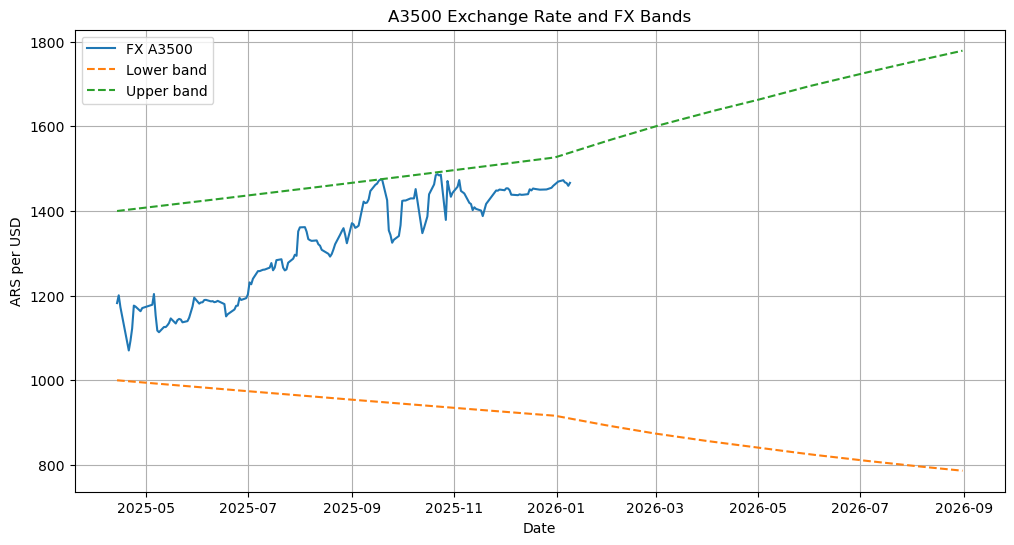

,Date,lower,upper,FX
0,2025-04-14,1000.000000,1400.000000,1182.4167
1,2025-04-15,999.665045,1400.464426,1200.8333
2,2025-04-16,999.330202,1400.929006,1172.8333
3,2025-04-17,998.995471,1401.393740,NaN
4,2025-04-18,998.660853,1401.858628,NaN
...,...,...,...,...
500,2026-08-27,787.877202,1775.207652,NaN
501,2026-08-28,787.486092,1776.088883,NaN
502,2026-08-29,787.095176,1776.970552,NaN
503,2026-08-30,786.704454,1777.852658,NaN


In [7]:
# 6) Merge 2025/26 bands + final chart

rem = get_rem_last()
fx  = get_a3500()

# Build bands
bands_2025 = build_bands_2025(start="2025-04-14")
bands_2026 = build_bands_2026(bands_2025, rem)

# Full daily bands
bands_total = (
    pd.concat([bands_2025, bands_2026], ignore_index=True)
      .sort_values("Date")
      .reset_index(drop=True)
)

# Merge FX (business days only) onto daily bands
df_final = (
    bands_total
      .merge(fx, on="Date", how="left")
      .loc[:, ["Date", "lower", "upper", "FX"]]
)


# CHART

fx_plot = df_final.dropna(subset=["FX"]).sort_values("Date")

plt.figure(figsize=(12, 6))
plt.plot(fx_plot["Date"], fx_plot["FX"], label="FX A3500")
plt.plot(df_final["Date"], df_final["lower"], linestyle="--", label="Lower band")
plt.plot(df_final["Date"], df_final["upper"], linestyle="--", label="Upper band")
plt.title("A3500 Exchange Rate and FX Bands")
plt.xlabel("Date")
plt.ylabel("ARS per USD")
plt.grid(True)
plt.legend()
plt.savefig("fx_a3500_bands.jpeg", dpi=300, bbox_inches="tight")
plt.show()

df_final
